<a href="https://colab.research.google.com/github/xgxg1314/CausalPINNs/blob/main/PI_DeepONet_pendulum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/drive")


Mounted at /content/drive


In [2]:


path = "/content/drive/MyDrive/Colab Notebooks/p22_Long_time_Integration_PI_DeepONets"

import os 

os.chdir(path)
!pwd



/content/drive/MyDrive/Colab Notebooks/p22_Long_time_Integration_PI_DeepONets


In [3]:

import numpy as onp



import jax.numpy as np
from jax import random, grad, vmap, jit
from jax.experimental import optimizers
from jax.experimental.ode import odeint
from jax.nn import relu
from jax.config import config

from jax.flatten_util import ravel_pytree


import itertools
from functools import partial

# 一般都会使用torch的dataset
from torch.utils import data

from tqdm import trange
import matplotlib.pyplot as plt

%matplotlib inline




/usr/local/lib/python3.7/dist-packages/jax/experimental/optimizers.py:30: FutureWarning: jax.experimental.optimizers is deprecated, import jax.example_libraries.optimizers instead
  FutureWarning)


In [4]:


# Define the neural net
def MLP(layers, activation=relu):
  ''' Vanilla MLP'''
  def init(rng_key):
      def init_layer(key, d_in, d_out):
          k1, k2 = random.split(key)
          glorot_stddev = 1. / np.sqrt((d_in + d_out) / 2.)
          W = glorot_stddev * random.normal(k1, (d_in, d_out))
          b = np.zeros(d_out)
          return W, b
      key, *keys = random.split(rng_key, len(layers))
      params = list(map(init_layer, keys, layers[:-1], layers[1:]))
      return params
  def apply(params, inputs):
      for W, b in params[:-1]:
          outputs = np.dot(inputs, W) + b
          inputs = activation(outputs)
      W, b = params[-1]
      outputs = np.dot(inputs, W) + b
      return outputs
  return init, apply


# Define the modified neural net
def modified_deeponet(layers, activation=relu):
  def xavier_init(key, d_in, d_out):
      glorot_stddev = 1. / np.sqrt((d_in + d_out) / 2.)
      W = glorot_stddev * random.normal(key, (d_in, d_out))
      b = np.zeros(d_out)
      return W, b

  def init(rng_key):
      subkey1,  subkey2 = random.split(rng_key)
      U1, b1 =  xavier_init(subkey1, layers[0], layers[1])
      U2, b2 =  xavier_init(subkey2, layers[0], layers[1])
      def init_layer(key, d_in, d_out):
          k1, k2 = random.split(key)
          W, b = xavier_init(k1, d_in, d_out)
          return W, b
      key, *keys = random.split(rng_key, len(layers))
      params = list(map(init_layer, keys, layers[:-1], layers[1:]))
      return (params, U1, b1, U2, b2) 

  def apply(params, inputs):
      params, U1, b1, U2, b2 = params
      U = activation(np.dot(inputs, U1) + b1)
      V = activation(np.dot(inputs, U2) + b2)
      for W, b in params[:-1]:
          outputs = activation(np.dot(inputs, W) + b)
          inputs = np.multiply(outputs, U) + np.multiply(1 - outputs, V) 
      W, b = params[-1]
      outputs = np.dot(inputs, W) + b
      return outputs
  return init, apply





In [5]:

## 构造数据集 ，为了产生批量训练样本
class DataGenerator(data.Dataset):
    def __init__(self, u, y, s, 
                 batch_size=64, rng_key=random.PRNGKey(1234)):
        'Initialization'
        self.u = u
        self.y = y
        self.s = s
        
        self.N = u.shape[0]
        self.batch_size = batch_size
        self.key = rng_key

    def __getitem__(self, index):
        'Generate one batch of data'
        self.key, subkey = random.split(self.key)
        inputs, outputs = self.__data_generation(subkey)
        return inputs, outputs

    @partial(jit, static_argnums=(0,))
    def __data_generation(self, key):
        'Generates data containing batch_size samples'
        idx = random.choice(key, self.N, (self.batch_size,), replace=True)
        s = self.s[idx,:]
        y = self.y[idx,:]
        u = self.u[idx,:]
        # Construct batch
        inputs = (u, y)
        outputs = s
        return inputs, outputs



In [6]:


# Define the model
class PI_DeepONet:
    def __init__(self, branch_layers, trunk_layers):    
        # Network initialization and evaluation functions
        self.branch_init, self.branch_apply = modified_deeponet(branch_layers, activation=np.tanh)
        self.trunk_init, self.trunk_apply = modified_deeponet(trunk_layers, activation=np.tanh)

        # Initialize
        branch_params = self.branch_init(rng_key = random.PRNGKey(1234))
        trunk_params = self.trunk_init(rng_key = random.PRNGKey(4321))
        params = (branch_params, trunk_params)

        # Use optimizers to set optimizer initialization and update functions
        self.opt_init, \
        self.opt_update, \
        self.get_params = optimizers.adam(optimizers.exponential_decay(1e-3, 
                                                                      decay_steps=5000, 
                                                                      decay_rate=0.9))
        self.opt_state = self.opt_init(params)

        _, self.unravel = ravel_pytree(params)

        # Logger
        self.itercount = itertools.count()
        self.loss_log = []
        self.loss_ics_log = []
        self.loss_res_log = []

    # Define DeepONet architecture
    def operator_net(self, params, u, y):
        branch_params, trunk_params = params
        B = self.branch_apply(branch_params, u)
        T = self.trunk_apply(trunk_params, y)

        B1 = B[:100]
        B2 = B[100:]

        T1 = T[:100]
        T2 = T[100:]

        s1 = np.sum(B1 * T1)
        s2 = np.sum(B2 * T2)

        return s1, s2

    # Define ODE residual
    def residual_net(self, params, u, y):

        s1, s2 = self.operator_net(params, u, y)

        def s1_fn(params, u, y):
          s1_fn, _ = self.operator_net(params, u, y)
          return s1_fn
        
        def s2_fn(params, u, y):
          _, s2_fn  = self.operator_net(params, u, y)
          return s2_fn

        s1_y = grad(s1_fn, argnums= 2)(params, u, y)
        s2_y = grad(s2_fn, argnums= 2)(params, u, y)

        res_1 = s1_y - s2
        res_2 = s2_y + 0.05 * s2 + 9.81 * np.sin(s1)

        return res_1, res_2

    # Define initial loss
    def loss_ics(self, params, batch):
        # Fetch data
        inputs, outputs = batch
        u, y = inputs

        s1 = outputs[:, 0:1]
        s2 = outputs[:, 1:2]

        # Compute forward pass
        s1_pred, s2_pred = vmap(self.operator_net, (None, 0, 0))(params, u, y)
        # Compute loss
        loss_s1 = np.mean((s1.flatten() - s1_pred)**2)
        loss_s2 = np.mean((s2.flatten() - s2_pred)**2)

        loss = loss_s1 + loss_s2
        return loss

    # Define residual loss
    def loss_res(self, params, batch):
        # Fetch data
        inputs, outputs = batch
        u, y = inputs

        # Compute forward pass
        res1_pred, res2_pred = vmap(self.residual_net, (None, 0, 0))(params, u, y)
        # Compute loss
        loss_res1 = np.mean((res1_pred)**2)
        loss_res2 = np.mean((res2_pred)**2)
        loss_res = loss_res1 + loss_res2
        return loss_res   

    # Define total loss
    def loss(self, params, ics_batch, res_batch):
        loss_ics = self.loss_ics(params, ics_batch)
        loss_res = self.loss_res(params, res_batch)
        loss =  loss_ics + loss_res
        return loss

    # Define a compiled update step
    @partial(jit, static_argnums=(0,))
    def step(self, i, opt_state, ics_batch, res_batch):
        params = self.get_params(opt_state)
        g = grad(self.loss)(params, ics_batch, res_batch)
        return self.opt_update(i, g, opt_state)

    # Optimize parameters in a loop
    def train(self, ics_dataset, res_dataset, nIter = 10000):
        ics_data = iter(ics_dataset)
        res_data = iter(res_dataset)

        pbar = trange(nIter)
        # Main training loop
        for it in pbar:
            ics_batch= next(ics_data)
            res_batch = next(res_data)

            self.opt_state = self.step(next(self.itercount), self.opt_state, ics_batch, res_batch)
            
            if it % 100 == 0:
                params = self.get_params(self.opt_state)

                # Compute losses
                loss_value = self.loss(params, ics_batch, res_batch)
                loss_ics_value = self.loss_ics(params, ics_batch)
                loss_res_value = self.loss_res(params, res_batch)

                # Store losses
                self.loss_log.append(loss_value)
                self.loss_ics_log.append(loss_ics_value)
                self.loss_res_log.append(loss_res_value)

                # Print losses
                pbar.set_postfix({'Loss': loss_value, 
                                  'loss_ics': loss_ics_value, 
                                  'loss_res': loss_res_value})
       
           
    # Evaluates predictions at test points  
    @partial(jit, static_argnums=(0,))
    def predict_s(self, params, U_star, Y_star):
        s1_pred, s2_pred = vmap(self.operator_net, (None, 0, 0))(params, U_star, Y_star)
        return s1_pred, s2_pred




In [7]:
# Hyper-parameters for ODE system
b = 0.05
g = 9.81
l = 1
m = 1

def system(s, t):
  s1 = s[0]
  s2 = s[1]
  ds1_dt = s2
  ds2_dt =  - (b/m) * s2 - g * np.sin(s1)
  ds_dt = [ds1_dt, ds2_dt]
  return ds_dt

# Geneate training data corresponding to one input sample
def generate_one_training_data(key, m=1, P=1, Q = 100):

    key_u, key_r = random.split(key)
    
    u_train =  random.uniform(key_u, (m,2), minval=-3, maxval=3)

    y_train = np.zeros((P,))
    s_train = u_train

    u_r_train = np.tile(u_train, (Q, 1))
    y_r_train =  random.uniform(key_r, shape=(Q,), minval=0.0, maxval=1.0)
    # y_r_train =  np.linspace(0, 1, Q)
    s_r_train = np.zeros((Q,1))

    return u_train, y_train, s_train, u_r_train, y_r_train, s_r_train

# Geneate test data corresponding to one input sample
def generate_one_test_data(key, m=1, P=100):

    # Input sensor locations and measurements
    u = random.uniform(key, (m, 2), minval=-2, maxval=2)
    # Output sensor locations and measurements
    y = np.linspace(0, 1, P)
    s = odeint(system, u.flatten(), y)

    # Tile inputs
    u = np.tile(u, (P, 1))

    return u, y, s 

# Geneate training data corresponding to N input sample
def generate_training_data(key, N, m, P, Q):
    keys = random.split(key, N)
    gen_fn = jit(lambda key: generate_one_training_data(key, m, P, Q))
    u_train, y_train, s_train, u_r_train, y_r_train, s_r_train = vmap(gen_fn)(keys)

    u_train = np.float32(u_train.reshape(N * P,-1))
    y_train = np.float32(y_train.reshape(N * P,-1))
    s_train = np.float32(s_train.reshape(N * P,-1))

    u_r_train = np.float32(u_r_train.reshape(N * Q,-1))
    y_r_train = np.float32(y_r_train.reshape(N * Q,-1))
    s_r_train = np.float32(s_r_train.reshape(N * Q,-1))

    return u_train, y_train, s_train, u_r_train, y_r_train,  s_r_train

# Geneate test data corresponding to N input sample
def generate_test_data(key, N, m, P):
    keys = random.split(key, N)
    gen_fn = jit(lambda key: generate_one_test_data(key, m, P))
    u, y, s = vmap(gen_fn)(keys)
    u = np.float32(u.reshape(N * P,-1))
    y = np.float32(y.reshape(N * P,-1))
    s = np.float32(s.reshape(N * P,-1))
    return u, y, s

# Compute relative l2 error over N test samples.
def compute_error(key, m, P):
    u_test, y_test, s_test = generate_test_data(key, 1, m, P)

    s_pred = model.predict_s(params, u_test, y_test)[:,None]
    s_y_pred = model.predict_s_y(params, u_test, y_test)

    error_s = np.linalg.norm(s_test - s_pred, 2) / np.linalg.norm(s_test, 2) 
    error_u = np.linalg.norm(np.cos(y_test)    - s_y_pred) / np.linalg.norm(u_test[::P_test].flatten()[:,None]) 

    return error_s, error_u





In [8]:
# Training data 
N_train = 50000
m = 1 # number of input sensors
P_train = 1   # number of output sensors (y = 0)
Q_train = 1000   # number of output sensors
key_train = random.PRNGKey(0) # use different key for generating training data 
u_train, y_train, s_train, u_r_train, y_r_train, s_r_train = generate_training_data(key_train, N_train, m, P_train, Q_train)




In [9]:
# Initialize model
branch_layers = [2, 100, 100, 100, 100, 100, 100, 200]
trunk_layers =  [1, 100, 100, 100, 100, 100, 100, 200]
model = PI_DeepONet(branch_layers, trunk_layers)




In [10]:
# Create data set
batch_size = 10000
ics_dataset = DataGenerator(u_train, y_train, s_train, batch_size)
res_dataset = DataGenerator(u_r_train, y_r_train, s_r_train, batch_size)




# 开始模型训练

In [ ]:
# Train
# model.train(ics_dataset, res_dataset, nIter=300000)



# 保存模型训练的参数和误差

In [ ]:
# Save PI-DeepONet model parameters and losses
# flat_params, _  = ravel_pytree(model.get_params(model.opt_state))
# np.save('pendulum_params.npy', flat_params)
# np.save('pendulum_loss_res.npy', model.loss_ics_log)
# np.save('pendulum_loss_ics.npy', model.loss_res_log)



# 直接加载模型训练的参数和误差（用于重新加载模型参数和前向传播）

In [11]:
# Restore PI-DeepONet model parameters
flat_params = np.load('pendulum_params.npy')
_, unravel = ravel_pytree(model.get_params(model.opt_state))

# 把模型的参数重新变回成原来的形状
pendulum_params = unravel(flat_params)



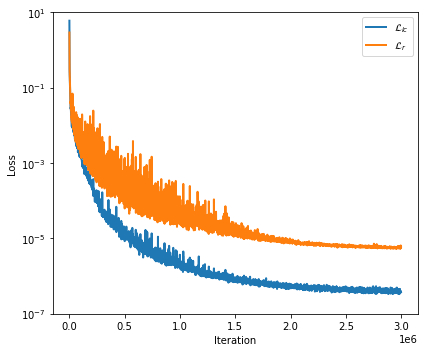

In [12]:
#Plot for loss function
loss_ics = np.load('pendulum_loss_ics.npy')
loss_res = np.load('pendulum_loss_res.npy')
iter = 1000 * np.arange(len(loss_ics))

fig = plt.figure(figsize = (6,5))
plt.plot(iter, loss_ics, lw=2, label='$\mathcal{L}_{ic}$')
plt.plot(iter, loss_res, lw=2, label='$\mathcal{L}_{r}$')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.yscale('log')
plt.ylim([1e-7, 1e1])
plt.legend()
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.tight_layout()
plt.show()





In [13]:
# Create the test data
T = 100 # Final time
dt = 1.0 
N = int(T / dt)

u0 = np.array([1.0, 1.0]) # initial state
y =  np.linspace(0, int(N * dt), int(100 * N)) 
s_exact = odeint(system, u0, y)




In [14]:
# Long time model prediction
P_test = 100  
u0_star = np.tile(u0, (P_test, 1))
y_star = np.linspace(0, dt, P_test).reshape(-1, 1)

s1_pred_0, s2_pred_0 = model.predict_s(pendulum_params, u0_star, y_star)
s1_pred = s1_pred_0
s2_pred = s2_pred_0

for k in range(1, N):
  u0 = np.hstack([s1_pred[-1], s2_pred[-1]])
  u_star = np.tile(u0, (P_test, 1))

  s1_pred_k, s2_pred_k = model.predict_s(pendulum_params, u_star, y_star)

  s1_pred = np.hstack([s1_pred, s1_pred_k])
  s2_pred = np.hstack([s2_pred, s2_pred_k])




In [15]:
# errors
error_s1 = np.linalg.norm(s_exact[:,0]  - s1_pred) / np.linalg.norm(s_exact[:,0])
error_s2 = np.linalg.norm(s_exact[:,1]  - s2_pred) / np.linalg.norm(s_exact[:,1])
print('error s1: {:.3e}, error s2: {:.3e}'.format(error_s1, error_s2))



error s1: 1.721e-02, error s2: 1.628e-02


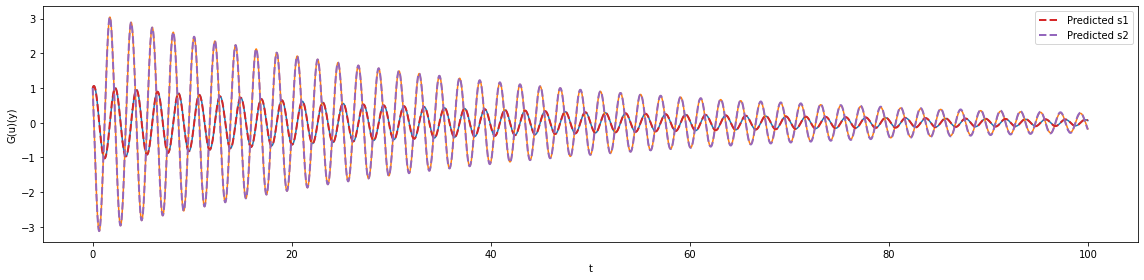

In [16]:
# Plot
fig = plt.figure(figsize=(16,4))
plt.plot(y, s_exact[:,0], color='C0')
plt.plot(y, s_exact[:,1], color='C1')
plt.plot(y, s1_pred, '--', label='Predicted s1', lw=2, color='C3')
plt.plot(y, s2_pred, '--', label='Predicted s2', lw=2, color='C4')
plt.xlabel('y')
plt.ylabel('G(u)(y)')
plt.xlabel('t')
plt.tight_layout()
plt.legend()
plt.show()


